In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
import Augmentor
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
from IPython.display import FileLink

In [3]:
class SeedlingDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        return image, int(labels)

In [4]:
data_dir = '/home/tyler/storage/plant_seedlings/'
storage_dir = data_dir + 'results/'
result_file = storage_dir + 'plant_seedling_results.csv'
image_size = 224
batch_size = 8
classes = listdir(data_dir + 'train/')
classes = sorted(classes, key=lambda item: (int(item.partition(' ')[0])
                               if item[0].isdigit() else float('inf'), item))
num_to_class = dict(zip(range(len(classes)), classes))
num_to_class

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

In [5]:
train = []
for index, label in enumerate(classes):
    path = data_dir + 'train/' + label + '/'
    for file in listdir(path):
        train.append(['{}/{}'.format(label, file), label, index])
    
df = pd.DataFrame(train, columns=['file', 'category', 'category_id',]) 
# df

In [6]:
train_data = df.sample(frac=0.7)
valid_data = df[~df['file'].isin(train_data['file'])]
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')
sample_submission.columns = ['file', 'category']
sample_submission['category_id'] = 0
# sample_submission

In [7]:
p_train = Augmentor.Pipeline()
p_train.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p_train.resize(probability=1, width=image_size, height=image_size, resample_filter="ANTIALIAS")
p_train.random_distortion(probability=0.3, grid_width=5, grid_height=5, magnitude=5)
p_train.skew_corner(probability=0.3, magnitude=0.7)
p_train.skew(probability=0.3, magnitude=0.7)
p_train.flip_random(probability=0.6)


p_test = Augmentor.Pipeline()
p_test.resize(probability=1, width=image_size, height=image_size, resample_filter="ANTIALIAS")

In [8]:
train_trans = transforms.Compose([
    transforms.Scale(256),
    p_train.torch_transform(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_trans = transforms.Compose([
    transforms.Scale(256),
    p_test.torch_transform(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = SeedlingDataset(train_data, data_dir + 'train/', transform = train_trans)
valid_set = SeedlingDataset(valid_data, data_dir + 'train/', transform = valid_trans)
test_set = SeedlingDataset(sample_submission, data_dir + 'test/', transform = valid_trans)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {
    'train': len(train_loader.dataset), 
    'valid': len(valid_loader.dataset)
}

In [9]:
def imshow(axis, inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

8
8
8
8
8


IndexError: list index out of range

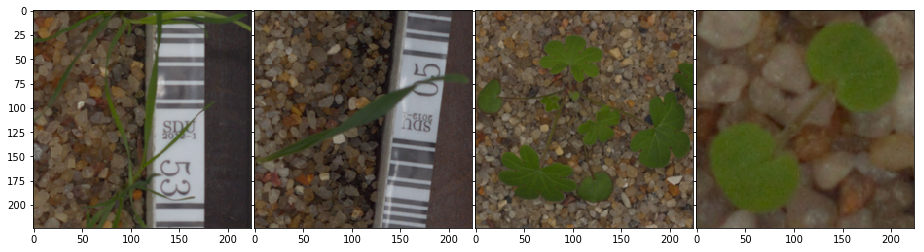

In [10]:
img, label = next(iter(valid_loader))
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    print(img.size()[0])
    ax = grid[i]
    imshow(ax, img[i])

In [19]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_batch = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                labels = labels.view(-1)
                
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
                running_batch +=1

            epoch_loss = running_loss / running_batch
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [28]:
use_gpu = torch.cuda.is_available()

model = torch.nn.Sequential(models.resnet50(pretrained=True),models.densenet161(pretrained=True))
# freeze all model parameters

for param in model.parameters():
    param.requires_grad = False   
    
num_ftrs_dens = model[1].classifier.in_features
num_ftrs_conv = model[0].fc.in_features

num_ftrs = num_ftrs_dens + num_ftrs_conv

model.classifier = torch.nn.Linear(num_ftrs, len(classes))
if use_gpu:
    model = model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

loaders = {'train':train_loader, 'valid':valid_loader, 'test': test_loader}

2208


In [29]:
start_time = time.time()
model = train_model(loaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch 1/10
----------


ValueError: Expected 4D tensor as input, got 2D tensor instead.

In [ ]:
path = storage_dir
torch.save(model.state_dict(), path + 'weights.torch')

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
unfrz_optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(unfrz_optim, step_size=7, gamma=0.1)
start_time = time.time()
model = train_model(loaders, model, criterion, unfrz_optim, exp_lr_scheduler, num_epochs=30)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

In [ ]:
torch.save(model.state_dict(), path + 'weights2.torch')

In [ ]:
model.load_state_dict(torch.load(path + 'weights2.torch'))

In [ ]:
model.eval()

In [ ]:
predictions = []
for i, (input, labels) in enumerate(test_loader):
    val = input.cuda()
    
    input = torch.autograd.Variable(val, volatile=True)
    output = model(input)
    prediction_matrix = func.softmax(output, dim=1).cpu().data.numpy()
    for index, pred in enumerate(prediction_matrix):
        predictions.append(pred.argmax())
    print('\r ' + str(i), end='') 
predictions


In [ ]:
submission = sample_submission.copy()
for index, prediction in enumerate(predictions):
    submission.set_value(index, 'category_id', prediction)
    submission.set_value(index, 'category', num_to_class[prediction])
submission

In [ ]:
submission.drop('category_id', axis=1, inplace=True)

In [ ]:
submission.columns = ['file', 'species']
submission.to_csv(result_file, sep=',', index=False)

In [ ]:
%cd ~/notebooks/plant_seedling
FileLink("plant_seedling_results.csv")